# 1. Import the Libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
import string
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.utils import np_utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,TimeDistributed,Bidirectional,Attention, Lambda
from tensorflow.keras.models import Model, Sequential,load_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as k

# 2. Developing the Attentive Layer
We will use this as a last layer to enchance the accuracy of output prediction

In [1]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

2023-02-16 04:52:15.016162: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# 3. Downloading the Gigaword Dataset

In [ ]:
from datasets import load_dataset
dataset = load_dataset("gigaword")

## Renaming the column names and saving it in csv format

In [ ]:
df = dataset['train'].to_pandas()
df.rename(columns={'document':'text','summary':'headlines'},inplace=True)
df.to_csv(r'.\gigaword_train.csv',index=False)

df = dataset['test'].to_pandas()
df.rename(columns={'document':'text','summary':'headlines'},inplace=True)
df.to_csv(r'.\gigaword_test.csv',index=False)

df = dataset['validation'].to_pandas()
df.rename(columns={'document':'text','summary':'headlines'},inplace=True)
df.to_csv(r'.\gigaword_valid.csv',index=False)

## Loading the saved CSV dataset

In [8]:
df_train=pd.read_csv('./gigaword_train.csv')
df_test=pd.read_csv('./gigaword_test.csv')
df_validate=pd.read_csv('./gigaword_valid.csv')

### Printing the dataset

In [9]:
df_train.head()

,text,summary
0,australia current account deficit shrunk recor...,sostok australian current account deficit narr...
1,least two people killed suspected bomb attack ...,sostok at least two dead in southern philippin...
2,australian shares closed percent monday follow...,sostok australian stocks close down percent eo...
3,south korea nuclear envoy kim sook urged north...,sostok envoy urges north korea to restart nucl...
4,south korea monday announced sweeping tax refo...,sostok skorea announces tax cuts to stimulate ...


# 3. Pre-processing Phase

In this stage, we will remove all unneeded symbols, characters, and other elements from the text that do not affect the problem's goal.

Here is the dictionary that we will use for expanding the contractions:

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

We will perform the below pre-processing tasks for our data:

1.Convert everything to lowercase

2.Contraction mapping

3.Remove (‘s)

4.Remove any text inside the parenthesis ( )

5.Eliminate punctuations and special characters

6.Remove stopwords

7.Remove single characters

In [ ]:
import re
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    # lower
    newString = text.lower()
    # Remove any text inside the parenthesis
    newString = re.sub(r'\([^)]*\)', '', newString)
    # remove double quotes
    newString = re.sub('"','', newString)
    # contraction mapping
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])  
    # remove 's
    newString = re.sub(r"'s\b","",newString)
    # Eliminate punctuations and special characters
    newString = re.sub("[^a-zA-Z]", " ", newString)
    # Remove stopwords
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    # Remove short words
    for i in tokens:
        if len(i)>1:                                                 
            long_words.append(i)   
    return (" ".join(long_words)).strip()

## Cleaning the Text Column

In [ ]:
cleaned_text = []
cleaned_text_test=[]
cleaned_text_valid=[]

for t in df_train['text']:
    cleaned_text.append(text_cleaner(t,0))

for t in df_test['text']:
    cleaned_text_test.append(text_cleaner(t,0))
    
for t in df_valid['text']:
    cleaned_text_valid.append(text_cleaner(t,0))

## Cleaning the Summary Column

In [ ]:
cleaned_summary = []
cleaned_summary_text = []
cleaned_summary_valid = []

for t in df_train['summary']:
    cleaned_summary.append(text_cleaner(t,1))
    
for t in df_test['summary']:
    cleaned_summary_test.append(text_cleaner(t,1))

for t in df_valid['summary']:
    cleaned_summary_valid.append(text_cleaner(t,1))

## Re-writing the cleaned text and summary

In [ ]:
df_train['text']=cleaned_text
df_train['summary']=cleaned_summary

df_test['text']=cleaned_text_test
df_test['summary']=cleaned_summary_test

df_valid['text']=cleaned_text_valid
df_valid['summary']=cleaned_summary_valid

## Droping empty rows

In [3]:
df_train.replace('', np.nan, inplace=True)
df_train.dropna(axis=0,inplace=True)

df_test.replace('', np.nan, inplace=True)
df_test.dropna(axis=0,inplace=True)

df_valid.replace('', np.nan, inplace=True)
df_valid.dropna(axis=0,inplace=True)

NameError: name 'df_train' is not defined

## Understanding the distribution of the sequences

Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence:

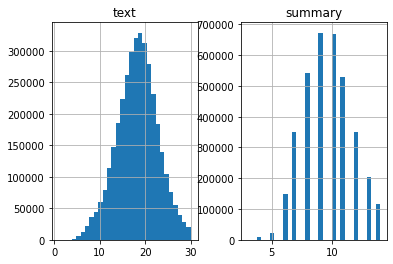

In [11]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df_train['text']:
      text_word_count.append(len(i.split()))

for i in df_train['summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

##### NOTE: We can fix the maximum length of the text to 27 and of summary 13 since that seems to be the majority summary length.

Let us understand the proportion of the length of summaries and text below 13 and 27 respectively

In [3]:
max_text_len=27
max_summary_len=13

In [24]:
cnt=0
for i in df_train['summary']:
    if(len(i.split()) <= max_summary_len):
        cnt=cnt+1
print(cnt/len(df_train['summary']))

0.9674311023921702


In [25]:
cnt=0
for i in df_train['text']:
    if(len(i.split()) <= max_text_len):
        cnt=cnt+1
print(cnt/len(df_train['text']))

0.9758745933869699


## Adding special tokens in the start and end of the sentence

In [ ]:
df_train['summary'] = df_test['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df_test['summary'] = df_test['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df_valid['summary'] = df_test['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

## Train-Test split and Preparing the tokenizer

In [35]:
x_train=df_train['text'].to_numpy()
y_train=df_train['summary'].to_numpy()
x_test=df_test['text'].to_numpy()
y_test=df_test['summary'].to_numpy()


x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_train))

## Rarewords and its Coverage on Reviews column

The threshold is taken as 4 which means word whose count is below 4 is considered as a rare word

In [36]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:", (cnt/tot_cnt)*100)
print("Total Coverage of rare words:", (freq/tot_freq)*100)

% of rare words in vocabulary: 0.5807224512172836
Total Coverage of rare words: 0.0023057233312542137


## Creating X and Y tokenizers 

In [37]:
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) # num_words: the maximum number of words to keep, based on word frequency.
x_tokenizer.fit_on_texts(list(x_train))

x_train_seq = x_tokenizer.texts_to_sequences(x_train)
x_test_seq = x_tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train_seq,maxlen=max_text_len,padding='post')
x_test = pad_sequences(x_test_seq,maxlen=max_text_len,padding='post')

In [38]:
x_vocab = x_tokenizer.num_words +1
x_vocab

97927

In [39]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [40]:
thresh=4

count=0
total_count=0
frequency=0
total_frequency=0

for key,value in y_tokenizer.word_counts.items():
    total_count=total_count+1
    total_frequency=total_frequency+value
    if(value<thresh):
        count=count+1
        frequency=frequency+value
    
print("% of rare words in vocabulary:",(count/total_count)*100)
print("Total Coverage of rare words:",(frequency/total_frequency)*100)

% of rare words in vocabulary: 0.8996681832175965
Total Coverage of rare words: 0.003717958052718753


In [41]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=total_count-count) 
y_tokenizer.fit_on_texts(list(y_train))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_train_seq    =   y_tokenizer.texts_to_sequences(y_train) 
y_test_seq   =   y_tokenizer.texts_to_sequences(y_test) 

#padding zero upto maximum length
y_train    =   pad_sequences(y_train_seq, maxlen=max_text_len, padding='post')
y_test   =   pad_sequences(y_test_seq, maxlen=max_text_len, padding='post')

#size of vocabulary
y_vocab  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_vocab))

Size of vocabulary in Y = 57941


In [42]:
ind=[]
for i in range(len(y_train)):
    count=0
    for j in y_train[i]:
        if j!=0:
            count=count+1
    if(count==2):
        ind.append(i)

y_train=np.delete(y_train,ind, axis=0)
x_train=np.delete(x_train,ind, axis=0)

In [43]:
ind=[]
for i in range(len(y_test)):
    count=0
    for j in y_test[i]:
        if j!=0:
            count=count+1
    if(count==2):
        ind.append(i)

y_test=np.delete(y_test,ind, axis=0)
x_test=np.delete(x_test,ind, axis=0)

## Saving the created numpy arrays and tokenziers 

In [44]:
from numpy import save

save(r'x_train.npy',x_train)
save(r'x_test.npy',x_test)
save(r'y_train.npy',y_train)
save(r'y_test.npy',y_test)

In [45]:
with open(r'x_tokenizer.pickle', 'wb') as handle:
    pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(r'y_tokenizer.pickle', 'wb') as handle:
    pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Loading the saved numpy arrays and tokenizers

In [4]:
from numpy import load

x_train = load(r'x_train.npy')
x_test = load(r'x_test.npy')
x_valid = load('x_validate.npy')
y_train = load(r'y_train.npy')
y_test = load(r'y_test.npy')
y_valid=load('y_validate.npy')

In [5]:
import pickle
with open(r'x_tokenizer.pickle', 'rb') as handle:
    x_tokenizer = pickle.load(handle)

with open(r'y_tokenizer.pickle', 'rb') as handle:
    y_tokenizer = pickle.load(handle)

x_vocab = x_tokenizer.num_words +1
y_vocab = y_tokenizer.num_words +1

print(f'X-Vocab: {x_vocab} \nY-Vocab: {y_vocab}')

X-Vocab: 97927 
Y-Vocab: 57941


# 4. Creating the Word2Vec Embedding Layer

Setting the window size as 5 and embedding dimesionality 300 as stated in research paper

In [6]:
word2id = x_tokenizer.word_index
id2word = x_tokenizer.index_word
vocab_size = x_vocab
emded_size=300
window_size=5

## Creating the function which will produce training batches

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = pad_sequences(context_words, maxlen=context_length)
            y = tf.keras.utils.to_categorical(label_word, vocab_size)
            yield (x, y)
            
            
# Test this out for some samples
i = 0
for x, y in generate_context_word_pairs(corpus=x_train, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['australia', 'current', 'account', 'deficit', 'shrunk', 'billion', 'dollars', 'lrb', 'billion', 'us'] -> Target (Y): record
Context (X): ['current', 'account', 'deficit', 'shrunk', 'record', 'dollars', 'lrb', 'billion', 'us', 'rrb'] -> Target (Y): billion
Context (X): ['account', 'deficit', 'shrunk', 'record', 'billion', 'lrb', 'billion', 'us', 'rrb', 'june'] -> Target (Y): dollars
Context (X): ['deficit', 'shrunk', 'record', 'billion', 'dollars', 'billion', 'us', 'rrb', 'june', 'quarter'] -> Target (Y): lrb
Context (X): ['shrunk', 'record', 'billion', 'dollars', 'lrb', 'us', 'rrb', 'june', 'quarter', 'due'] -> Target (Y): billion
Context (X): ['record', 'billion', 'dollars', 'lrb', 'billion', 'rrb', 'june', 'quarter', 'due', 'soaring'] -> Target (Y): us
Context (X): ['billion', 'dollars', 'lrb', 'billion', 'us', 'june', 'quarter', 'due', 'soaring', 'commodity'] -> Target (Y): rrb
Context (X): ['dollars', 'lrb', 'billion', 'us', 'rrb', 'quarter', 'due', 'soaring', 'commod

## Creating the Word2Vec model

This model will act as a first layer in our Attentive Sequence to Sequence Model

In [8]:
import tensorflow.keras.backend as k
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,TimeDistributed,Bidirectional,Attention, Lambda
from tensorflow.keras.models import Model, Sequential,load_model

k.clear_session()
with tf.device('/gpu:1'):
    cbow = Sequential();
    cbow.add(Embedding(input_dim=vocab_size, output_dim=emded_size, input_length=window_size*2));
    cbow.add(Lambda(lambda x: k.mean(x, axis=1), output_shape=(emded_size,)));
    cbow.add(Dense(vocab_size, activation='softmax'));
    cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop');

print(cbow.summary());

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 300)           29378100  
_________________________________________________________________
lambda (Lambda)              (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 97927)             29476027  
Total params: 58,854,127
Trainable params: 58,854,127
Non-trainable params: 0
_________________________________________________________________
None


2023-02-16 04:52:34.172795: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-16 04:52:34.173803: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-16 04:52:34.449111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: Tesla V100-DGXS-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.72GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-16 04:52:34.450149: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Found device 1 with properties: 
pciBusID: 0000:08:00.0 name: Tesla V100-DGXS-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.72GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-16 04:52:34.452535: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Found device 2 with properties: 
pciBusID: 0000:0e:00.0 name: Tesl

In [9]:
weights = cbow.get_weights()[0]
weights = weights[1:]
weights

array([[-0.03713595, -0.03713151, -0.03945891, ..., -0.04383446,
         0.01875928,  0.00950094],
       [-0.03075793,  0.03271589, -0.03610778, ...,  0.02128861,
         0.00047736,  0.03518878],
       [-0.00527374,  0.02335833, -0.0175792 , ..., -0.03730728,
         0.036261  , -0.03657601],
       ...,
       [ 0.03451934, -0.0452996 , -0.02604081, ..., -0.00889795,
         0.00864307,  0.04188018],
       [-0.04608679,  0.02723633,  0.02396525, ..., -0.03396793,
        -0.00232814,  0.04900494],
       [ 0.0392028 ,  0.00392539,  0.00334841, ...,  0.03203825,
         0.03364015, -0.04880544]], dtype=float32)

## Creating the embedding layer

In [10]:
wv_layer = Embedding(vocab_size-1,
                     300,
                     mask_zero=False,
                     weights=[weights],
                     input_length=max_text_len,
                     trainable=True)

# 5. Creating the Attentive Seq2Seq Model

Creating the architecture of Attentive Seq2Seq model with the latent_dim of 200 and embedding dimensionality of 300 using bi-directional LSTM layers as encoders and decoders as stated in research paper

In [34]:
k.clear_session()

latent_dim = 200
embedding_dim = 300

# Encoder
encoder_inputs = Input(shape=(max_text_len, ),name='Encoder_Inputs')

# Embedding layer
enc_emb = wv_layer(encoder_inputs)

# Encoder LSTM 1 
encoder_lstm1 = Bidirectional(LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.2,
                     recurrent_dropout=0.2,name='Encoder_BiLSTM_Layer1'))
(encoder_output1, forward_state_h1, forward_state_c1,backward_state_h1,backward_state_c1) = encoder_lstm1(enc_emb)
state_h1=Concatenate()([forward_state_h1,backward_state_h1])
state_c1=Concatenate()([forward_state_c1,backward_state_c1])

# Encoder LSTM 2
encoder_lstm2 = Bidirectional(LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.2,
                     recurrent_dropout=0.2,name='Encoder_BiLSTM_Layer2'))
(encoder_outputs, forward_state_h2, forward_state_c2,backward_state_h2,backward_state_c2) = encoder_lstm2(encoder_output1)
state_h=Concatenate()([forward_state_h2,backward_state_h2])
state_c=Concatenate()([forward_state_c2,backward_state_c2])

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ),name='Decoder_Inputs')

# Embedding layer
dec_emb_layer = Embedding(y_vocab, embedding_dim, trainable=True, name='Decoder_Embedding_Inputs')
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM1
decoder_lstm = LSTM(latent_dim*2, return_sequences=True,
                    return_state=True, dropout=0.2,
                    recurrent_dropout=0.2,name='Decoder_LSTM_Layer')
(decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention Layer
attn_layer = AttentionLayer(name='Attention_Layer')
attn_out,attn_states=attn_layer([encoder_outputs,decoder_outputs])

decoder_concat_input=Concatenate(axis=-1,name='Concat_layer')([decoder_outputs,attn_out])
# Dense layer
decoder_dense = TimeDistributed(Dense(y_vocab, activation='softmax',name='TimeDistribution_Layer'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs,name='Attn_Seq2Seq')

model.summary()


Model: "Attn_Seq2Seq"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_Inputs (InputLayer)     [(None, 27)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 27, 300)      29377800    Encoder_Inputs[0][0]             
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 27, 400), (N 801600      embedding_1[2][0]                
__________________________________________________________________________________________________
Decoder_Inputs (InputLayer)     [(None, None)]       0                                            
_______________________________________________________________________________________

### Creating the learning rate scheduler

This will reduce the learning rate by 25% after each epoch. Initially, lr is set to 0.002 as stated in research paper

In [35]:
from tensorflow.keras.callbacks import LearningRateScheduler
import math
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.002
    drop = 0.75
    epochs_drop = 1.0
    lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop))
    return lrate

### Creating Adam Optimizer

Creating Adam optimizer with loss evaluation as 'sparse_categorical_crossentropy'

In [36]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0), loss='sparse_categorical_crossentropy')
lrate = LearningRateScheduler(step_decay,verbose=1)

### Creating Early Stopping 

It will stop training the model if the val_loss does not decreases after 2 consecutive epochs 

In [41]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

checkpoint_filepath = 'Attentive Seq2Seq Model'
checkpoint= tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True)

In [43]:
with tf.device('/gpu:0'):
    history = model.fit(
        [x_train, y_train[:, :-1]],
        y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:],
        epochs=20,
        callbacks=[es,checkpoint,lrate],
        batch_size=64,
        shuffle=True,
        use_multiprocessing=True,
        workers=-1,
        validation_data=([x_valid, y_valid[:, :-1]],
                         y_valid.reshape(y_valid.shape[0], y_valid.shape[1], 1)[:
                         , 1:]),
        )

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.002.
7057/7057 [==============================] - 9066s 1s/step - loss: 1.2910 - val_loss: 1.1132

Epoch 00001: val_loss improved from inf to 1.11319, saving model to Attentive Seq2Seq Model


2023-02-16 07:46:33.258384: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Attentive Seq2Seq Model/assets
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0015.
7057/7057 [==============================] - 8772s 1s/step - loss: 0.9648 - val_loss: 1.0492

Epoch 00002: val_loss improved from 1.11319 to 1.04918, saving model to Attentive Seq2Seq Model
INFO:tensorflow:Assets written to: Attentive Seq2Seq Model/assets
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0011250000000000001.
7057/7057 [==============================] - 8766s 1s/step - loss: 0.8864 - val_loss: 1.0269

Epoch 00003: val_loss improved from 1.04918 to 1.02692, saving model to Attentive Seq2Seq Model
INFO:tensorflow:Assets written to: Attentive Seq2Seq Model/assets
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00084375.
7057/7057 [==============================] - 8750s 1s/step - loss: 0.8403 - val_loss: 1.0189

Epoch 00004: val_loss improved from 1.02692 to 1.01891, saving mod

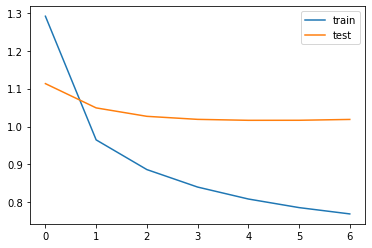

In [44]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [45]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

### Inference

Set up the inference for the encoder and decoder:

In [46]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim*2))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [47]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [48]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0, 2):
    print("Review:",seq2text(x_test[i]))
    print("Original summary:",seq2summary(y_test[i]))
    print("Predicted summary:",decode_sequence(x_test[i].reshape(1,max_text_len)))
    print("\n")

# 6. Rouge Scores

Calculating the Rouge scores and saving it in CSV file for Graph Plotting and Analysis.

In [ ]:
from rouge import Rouge
ROUGE = Rouge()
Original_summary = list()
Predicted_summary = list()
for i in range(len(x_test)):
    Review = seq2text(x_test[i])
    Original_summary.append(seq2summary(y_test[i]))
    Predicted_summary.append(decode_sequence(x_test[i].reshape(1,max_text_len)))
    
scores = ROUGE.get_scores(Predicted_summary,Original_summary,avg=True)
print(scores)

In [ ]:
df = pd.DataFrame(scores)
df.to_csv('./Attentive_Results.csv')
print(df)